# Heterogenous Agent Neoclassical Model - HANC

In [76]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})
import pandas as pd
from HANCModel import HANCModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 2: compute steady-states


Low INEQUALITY SS RESULTS
beta = 0.901471, K = 4.0000, Y = 1.0000, r = 0.0500, w = 0.6667
shocks: Gamma upsilon 
unknowns: K z_scale 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production_firm
  rK               0.0e+00
  w                0.0e+00
  Y                0.0e+00
  I                0.0e+00
 blocks.mutual_fund
  A                0.0e+00
  r                0.0e+00
 hh
  A_hh             5.7e-10
  C_hh             5.9e-11
  Z_hh             8.1e-15
  U_hh             1.0e-09
 blocks.market_clearing
  clearing_A       5.7e-10 [target]
  clearing_Y       5.9e-11
  clearing_Z       1.3e-14 [target]
production_firm: [Gamma,K] -> [rK,w,Y,I]
mutual_fund: [K,rK] -> [A,r]
hh: [r,upsilon,w,z_scale] -> [A_hh,C_hh,Z_hh,U_hh]
market_clearing: [A,A_hh,Y,C_hh,Z_hh,I] -> [clearing_A,clearing_Y,clearing_Z]


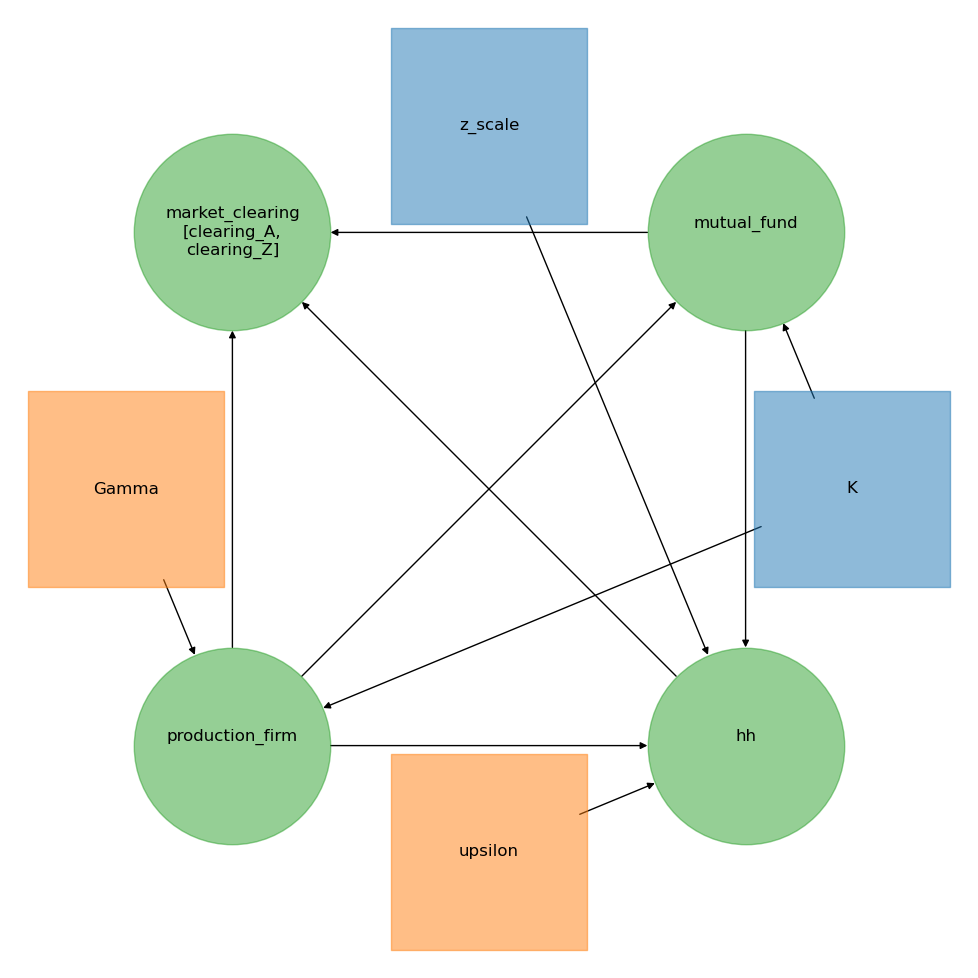

In [77]:
benchmark = HANCModelClass()
benchmark.par.upsilon_ss = 1.0  # low income risk

benchmark.prepare_hh_ss()
benchmark.find_ss(method='beta', do_print=False, beta_guess=0.95, K_guess=4.0, z_scale_guess=1.0)
print('\nLow INEQUALITY SS RESULTS')
model=benchmark
par = model.par
ss = model.ss
path = model.path
sim = model.sim
print(f'beta = {par.beta:.6f}, K = {ss.K:.4f}, Y = {ss.Y:.4f}, r = {ss.r:.4f}, w = {ss.w:.4f}')
benchmark.test_path()
beta_star   = par.beta
Gamma_star  = getattr(par, 'Gamma_ss', getattr(ss, 'Gamma', np.nan))
delta_star  = getattr(par, 'delta',    getattr(ss, 'delta', np.nan))
benchmark.info(only_blocks=True)
benchmark.draw_DAG(figsize=(10,10))


In [78]:


high_inequality = HANCModelClass(name='high inequality')

high_inequality.par.upsilon_ss = 1.5
high_inequality.par.beta       = beta_star

high_inequality.par.Gamma_ss   = Gamma_star
high_inequality.par.delta      = delta_star

high_inequality.prepare_hh_ss()
high_inequality.find_ss(method='direct', do_print=False, K_guess=ss.K, z_scale_guess=1.0)

print('\nHIGH INEQUALITY SS RESULTS')
print(f"beta = {high_inequality.par.beta:.6f}, K = {high_inequality.ss.K:.4f}, Y = {high_inequality.ss.Y:.4f}, r = {high_inequality.ss.r:.4f}, w = {high_inequality.ss.w:.4f}")
goods_diff = high_inequality.ss.Y - (high_inequality.ss.C_hh + high_inequality.ss.I)
print(f"Goods market excess: {goods_diff:.3e}")



HIGH INEQUALITY SS RESULTS
beta = 0.901471, K = 6.4454, Y = 1.1724, r = 0.0273, w = 0.7816
Goods market excess: 1.054e-10


# Question 3: comparative statics

In [79]:
names = ['Y', 'C_hh', 'I', 'K', 'w', 'r', 'rK', 'U_hh']
for name in names:
    print(f"{name:>6} | {getattr(benchmark.ss, name):>10.4f} -> {getattr(high_inequality.ss, name):>10.4f} | {100*(getattr(high_inequality.ss, name)-getattr(benchmark.ss, name))/np.abs(getattr(benchmark.ss, name)):>6.2f}%")


     Y |     1.0000 ->     1.1724 |  17.24%
  C_hh |     0.8667 ->     0.9575 |  10.48%
     I |     0.1333 ->     0.2148 |  61.14%
     K |     4.0000 ->     6.4454 |  61.14%
     w |     0.6667 ->     0.7816 |  17.24%
     r |     0.0500 ->     0.0273 | -45.41%
    rK |     0.0833 ->     0.0606 | -27.24%
  U_hh |    -4.1890 ->    -6.7814 | -61.89%


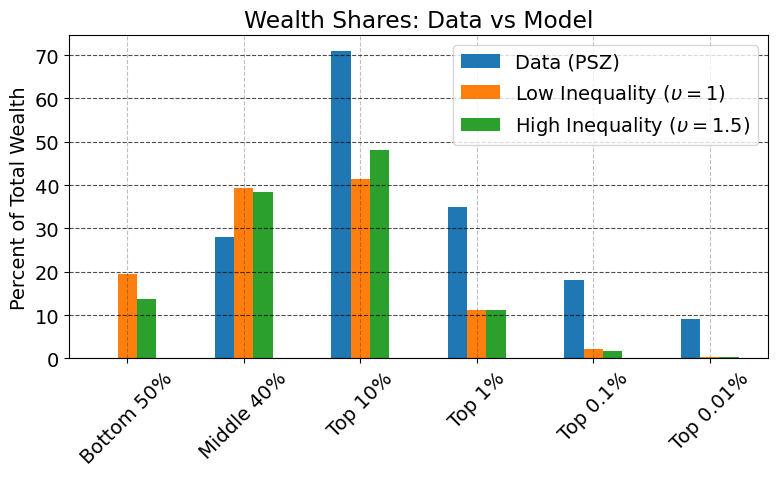


Wealth Shares Comparison (Percent of Total Wealth):
            Data (PSZ)  Low Inequality ($\upsilon=1$)  \
Bottom 50%         0.0                           19.4   
Middle 40%        28.0                           39.2   
Top 10%           71.0                           41.4   
Top 1%            35.0                           11.2   
Top 0.1%          18.0                            2.3   
Top 0.01%          9.0                            0.3   

            High Inequality ($\upsilon=1.5$)  
Bottom 50%                              13.7  
Middle 40%                              38.3  
Top 10%                                 48.0  
Top 1%                                  11.2  
Top 0.1%                                 1.6  
Top 0.01%                                0.2  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_wealth_shares(a, D):
    """Compute wealth shares across population quantiles using correct marginal distribution over assets."""
    # Remove redundant leading dimension
    a = np.squeeze(a)  # shape (11, 1000)
    D = np.squeeze(D)  # shape (11, 1000)

    D_a = np.sum(D, axis=0)  # now shape (1000,)
    a_grid = np.mean(a, axis=0)  # average assets over z-grid for each asset point

    D_a /= np.sum(D_a)

    sort_idx = np.argsort(a_grid)
    a_sorted = a_grid[sort_idx]
    D_sorted = D_a[sort_idx]

    cum_pop = np.cumsum(D_sorted)
    total_wealth = np.sum(a_sorted * D_sorted)

    def wealth_share(p_lo, p_hi):
        lo = np.searchsorted(cum_pop, p_lo)
        hi = np.searchsorted(cum_pop, p_hi)
        wealth_slice = np.sum(a_sorted[lo:hi] * D_sorted[lo:hi])
        return 100 * wealth_slice / total_wealth

    shares = {
        'Bottom 50%': wealth_share(0.0, 0.5),
        'Middle 40%': wealth_share(0.5, 0.9),
        'Top 10%': wealth_share(0.9, 1.0),
        'Top 1%': wealth_share(0.99, 1.0),
        'Top 0.1%': wealth_share(0.999, 1.0),
        'Top 0.01%': wealth_share(0.9999, 1.0)
    }

    return shares



def plot_combined_wealth_shares(benchmark, high_inequality):
    """Plot PSZ data and both model scenarios on the same figure."""
    low_shares = compute_wealth_shares(benchmark.ss.a, benchmark.ss.Dbeg)
    high_shares = compute_wealth_shares(high_inequality.ss.a, high_inequality.ss.Dbeg)

    # PSZ data (2019)
    psz_data = pd.Series({
        'Bottom 50%': 0.0,
        'Middle 40%': 28.0,
        'Top 10%': 71.0,
        'Top 1%': 35.0,
        'Top 0.1%': 18.0,
        'Top 0.01%': 9.0
    })

    df = pd.DataFrame({
        'Data (PSZ)': psz_data,
        'Low Inequality ($\\upsilon=1$)': pd.Series(low_shares),
        'High Inequality ($\\upsilon=1.5$)': pd.Series(high_shares)
    })

    ax = df.plot(kind='bar', figsize=(8,5))
    plt.title("Wealth Shares: Data vs Model")
    plt.ylabel("Percent of Total Wealth")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nWealth Shares Comparison (Percent of Total Wealth):")
    print(df.round(1))

# Run combined plot
plot_combined_wealth_shares(benchmark, high_inequality)



# Question 4: compute transitions 

In [ ]:
# Initialize the ini dict at the old steady state
ini = {}
ini['Dbeg'] = benchmark.ss.Dbeg.copy()
# --- Compute Jacobians for benchmark ---
benchmark.compute_jacs(do_print=True, skip_shocks=True)

# --- Initialize the transition path at the steady state ---
benchmark._set_ini(ini_input='ss')

# --- Define the initial state dictionary ---
ini = {}
ini['Dbeg'] = benchmark.ss.Dbeg.copy()    
ini['K'] = benchmark.ss.K                 
ini['z_scale'] = benchmark.ss.z_scale     

# --- Create the permanent upsilon jump (from 1.0 → 1.5) ---
dupsilon = np.zeros(benchmark.par.T)
dupsilon[:] = high_inequality.par.upsilon_ss - benchmark.par.upsilon_ss
shock_jump = {'dupsilon': dupsilon}

# --- Compute the transition path ---
trans_jump = benchmark.find_transition_path(ini=ini, shocks=shock_jump, do_print=True)
trans = copy.deepcopy(benchmark.path)       


household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.9 secs
curly_Y and curly_D calculated for upsilon         in 0.9 secs
curly_Y and curly_D calculated for w               in 0.9 secs
curly_Y and curly_D calculated for z_scale         in 0.9 secs
curly_E calculated in 0.4 secs
builiding blocks combined in 5.7 secs
household Jacobian computed in 9.6 secs

full Jacobians:
full Jacobian to unknowns computed in 1.9 secs [in evaluate_blocks(): 1.0 secs]
finding the transition path:
 it =   0 -> max. abs. error = 8.45e+00
   8.45e+00 in clearing_A
   6.67e-01 in clearing_Z
 it =   1 -> max. abs. error = 4.14e+00
   4.14e+00 in clearing_A
   4.45e-01 in clearing_Z
 it =   2 -> max. abs. error = 7.32e-01
   7.32e-01 in clearing_A
   1.03e-01 in clearing_Z
 it =   3 -> max. abs. error = 3.22e-01
   3.22e-01 in clearing_A
   2.19e-02 in clearing_Z
 it =   4 -> max. abs. error = 1.16e-01
   1.16e-01 in clearing_

In [ ]:
import numpy as np, copy

benchmark.compute_jacs(do_print=True, skip_shocks=True)

ini = 'ss'

upsilon_T = 30
upsilon_lo = benchmark.par.upsilon_ss           # should be 1.0
upsilon_hi = high_inequality.par.upsilon_ss     # should be 1.5

dupsilon = np.zeros(benchmark.par.T)
dupsilon[:upsilon_T] = np.linspace(0.0, upsilon_hi - upsilon_lo, upsilon_T)
dupsilon[upsilon_T:] = (upsilon_hi - upsilon_lo)  # <-- keep at the higher level permanently

shock = {'dupsilon': dupsilon}  # dict keys must be 'd' + variable name

benchmark.find_transition_path(ini=ini, shocks=shock, do_print=True)

trans_gradual = copy.deepcopy(benchmark.path)

high_inequality.path = copy.deepcopy(trans_gradual)

print("NaNs in trans_gradual.r?  ", np.isnan(trans_gradual.r).any())
print("NaNs in trans_gradual.w?  ", np.isnan(trans_gradual.w).any())
print("First 5 of upsilon path (level):",
      (benchmark.par.upsilon_ss + shock['dupsilon'])[:5],
      " ... last 5:",
      (benchmark.par.upsilon_ss + shock['dupsilon'])[-5:])


household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.9 secs
curly_Y and curly_D calculated for upsilon         in 0.9 secs
curly_Y and curly_D calculated for w               in 1.0 secs
curly_Y and curly_D calculated for z_scale         in 1.0 secs
curly_E calculated in 0.6 secs
builiding blocks combined in 8.6 secs
household Jacobian computed in 13.0 secs

full Jacobians:
full Jacobian to unknowns computed in 2.8 secs [in evaluate_blocks(): 1.6 secs]
finding the transition path:
 it =   0 -> max. abs. error = 8.45e+00
   8.45e+00 in clearing_A
   6.67e-01 in clearing_Z
 it =   1 -> max. abs. error = 4.14e+00
   4.14e+00 in clearing_A
   4.45e-01 in clearing_Z
 it =   2 -> max. abs. error = 7.44e-01
   7.44e-01 in clearing_A
   1.05e-01 in clearing_Z
 it =   3 -> max. abs. error = 3.21e-01
   3.21e-01 in clearing_A
   2.16e-02 in clearing_Z
 it =   4 -> max. abs. error = 1.13e-01
   1.13e-01 in clearing

In [83]:
trans_progressive = copy.deepcopy(high_inequality.path)


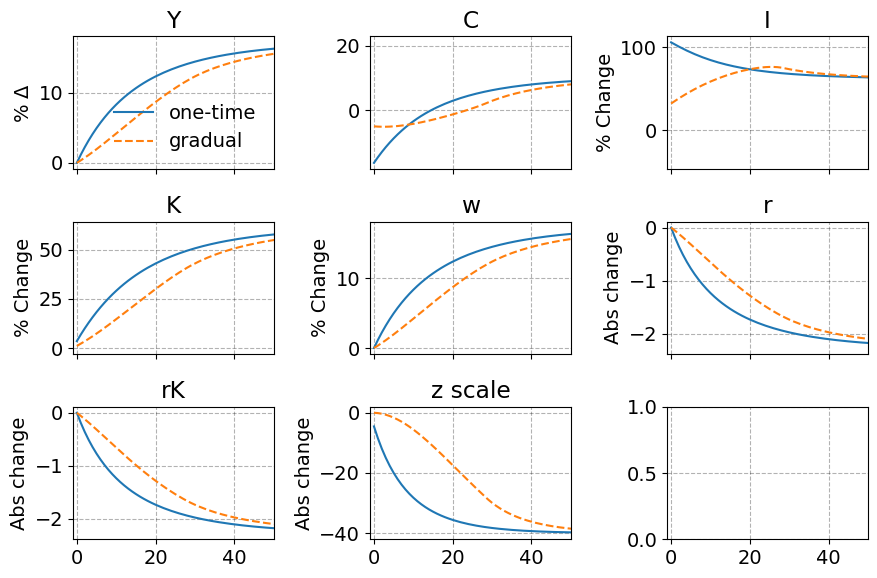

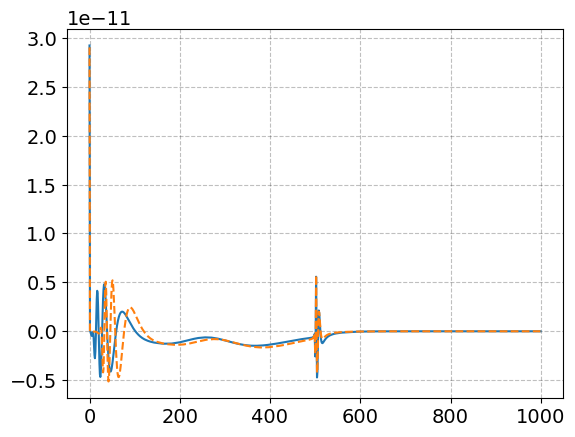

In [ ]:
# use this code to plot your results 
def get_pc_ini(trans, var):
    var_ss = getattr(benchmark.ss, var)
    var_trans = getattr(trans, var)
    return 100 * (var_trans - var_ss) / var_ss

def get_ac_ini(trans, var):
    var_ss = getattr(benchmark.ss, var)
    var_trans = getattr(trans, var)
    return 100 * (var_trans - var_ss)

fig, axs = plt.subplots(nrows=3, ncols=3,
                        figsize=(9,6), sharex=True, sharey=False)

# Normalize axs to 1D list for easy iteration
axs = np.atleast_1d(axs).ravel()

axs[0].plot(get_pc_ini(trans, 'Y'), label = 'one-time'); axs[0].set_title("Y")
axs[0].plot(get_pc_ini(trans_gradual, 'Y'), linestyle = '--', label = 'gradual'); axs[0].set_title("Y")
axs[0].set_ylabel('% $\Delta$')

axs[1].plot(get_pc_ini(trans, 'C_hh')); axs[1].set_title("C")
axs[1].plot(get_pc_ini(trans_gradual, 'C_hh'), linestyle = '--'); axs[1].set_title("C")
axs[0].set_ylabel('% $\Delta$')

axs[2].plot(get_pc_ini(trans, 'I')); axs[2].set_title("I")
axs[2].plot(get_pc_ini(trans_gradual, 'I'), linestyle = '--'); axs[2].set_title("I")
axs[2].set_ylabel('% Change')

axs[3].plot(get_pc_ini(trans, 'K')); axs[3].set_title("K")
axs[3].plot(get_pc_ini(trans_gradual, 'K'), linestyle = '--'); axs[3].set_title("K")
axs[3].set_ylabel('% Change')

axs[4].plot(get_pc_ini(trans, 'w')); axs[4].set_title("w")
axs[4].plot(get_pc_ini(trans_gradual, 'w'), linestyle = '--'); axs[4].set_title("w")
axs[4].set_ylabel('% Change')

axs[5].plot(get_ac_ini(trans, 'r')); axs[5].set_title("r")
axs[5].plot(get_ac_ini(trans_gradual, 'r'), linestyle = '--'); axs[5].set_title("r")
axs[5].set_ylabel('Abs change')

axs[6].plot(get_ac_ini(trans, 'rK')); axs[6].set_title("rK")
axs[6].plot(get_ac_ini(trans_gradual, 'rK'), linestyle = '--'); axs[6].set_title("rK")
axs[6].set_ylabel('Abs change')

axs[7].plot(get_ac_ini(trans, 'z_scale'))
axs[7].plot(get_ac_ini(trans_gradual, 'z_scale'), linestyle = '--'); axs[7].set_title("z scale")
axs[7].set_ylabel('Abs change')

for ax in axs.flat:
    ax.grid(True, alpha=0.3)
axs[0].set_xlim(-1, 50) # applies to all subplots because sharex=True
axs[0].legend(frameon=False)
#fig.supxlabel("Years")
#fig.supylabel("% Change")
fig.tight_layout()
plt.show()

plt.plot(trans.clearing_Y)
plt.plot(trans_gradual.clearing_Y, linestyle = '--')


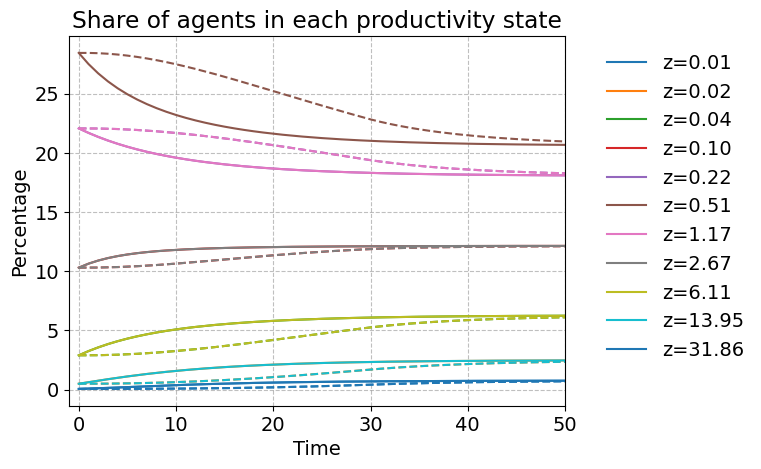

In [85]:
D_trans = trans.Dbeg.sum(axis=(1, 3));  D_trans /= D_trans.sum(axis=1, keepdims=True)
D_trans_progressive = trans_gradual.Dbeg.sum(axis=(1, 3));  D_trans_progressive /= D_trans_progressive.sum(axis=1, keepdims=True)
i = 0
for iz in range(benchmark.par.Nz):
    plt.plot(D_trans[:, iz] * 100,
             label=f"z={benchmark.par.z_grid[iz]:.2f}",
             color=f'C{i}')
    plt.plot(D_trans_progressive[:, iz] * 100,
             linestyle='--',
             color=f'C{i}')
    i += 1

plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(-1, 50)
plt.title('Share of agents in each productivity state')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.show()


# Question 5: sequence of myopic shocks

In [ ]:
trans_myopic = []
K_guess = benchmark.ss.K
ini_myopic = {}
ini_myopic['Dbeg'] = benchmark.ss.Dbeg.copy()
ini_myopic['K'] = benchmark.ss.K
ini_myopic['z_scale'] = benchmark.ss.z_scale
upsilon_path = np.linspace(benchmark.par.upsilon_ss, high_inequality.par.upsilon_ss, upsilon_T//3)
for t in range(1, upsilon_T//3):
    upsilon = upsilon_path[t]
    print(f"Step {t}: upsilon = {upsilon:.3f}")

    # --- a. Copy moel and set new upsilon ---
    _model = benchmark.copy()
    _model.par.upsilon_ss = upsilon

    _model.find_ss(do_print=False)   # recompute steady state

    _ini = {
        'Dbeg': ini_myopic['Dbeg'],
        'K': ini_myopic['K'],
        'z_scale': ini_myopic['z_scale']
    }

    _trans = _model.find_transition_path(ini=_ini, shocks=[], do_print=False)
    trans_myopic.append(copy.deepcopy(_model.path))


    ini_myopic['Dbeg'] = _model.ss.Dbeg.copy()
    ini_myopic['K'] = _model.ss.K
    ini_myopic['z_scale'] = _model.ss.z_scale


Step 1: upsilon = 1.056
Step 2: upsilon = 1.111
Step 3: upsilon = 1.167
Step 4: upsilon = 1.222
Step 5: upsilon = 1.278
Step 6: upsilon = 1.333
Step 7: upsilon = 1.389
Step 8: upsilon = 1.444
Step 9: upsilon = 1.500


In [87]:
import numpy as np

# note: nothing to do here, this code just joins the different pieces of the transition together

vars = ['K', 'rK', 'w', 'Y', 'I', 'A', 'r', 'upsilon', 'z_scale', 'C_hh', 'clearing_Y', 'clearing_A', 'clearing_Z']
full_trans = {}
T = benchmark.par.T
n_segments = len(trans_myopic)

for var in vars:
    # initialize with NaNs so we don't accidentally leave old values
    full_trans[var] = np.full(T, np.nan)
    for t in range(n_segments):
        start = 3 * t              # each transition is put starting at 3*t
        segment = getattr(trans_myopic[t], var)
        seg_arr = np.asarray(segment).flatten()
        seg_len = len(seg_arr)
        end = min(start + seg_len, T)
        if start < end:
            full_trans[var][start:end] = seg_arr[: end - start]

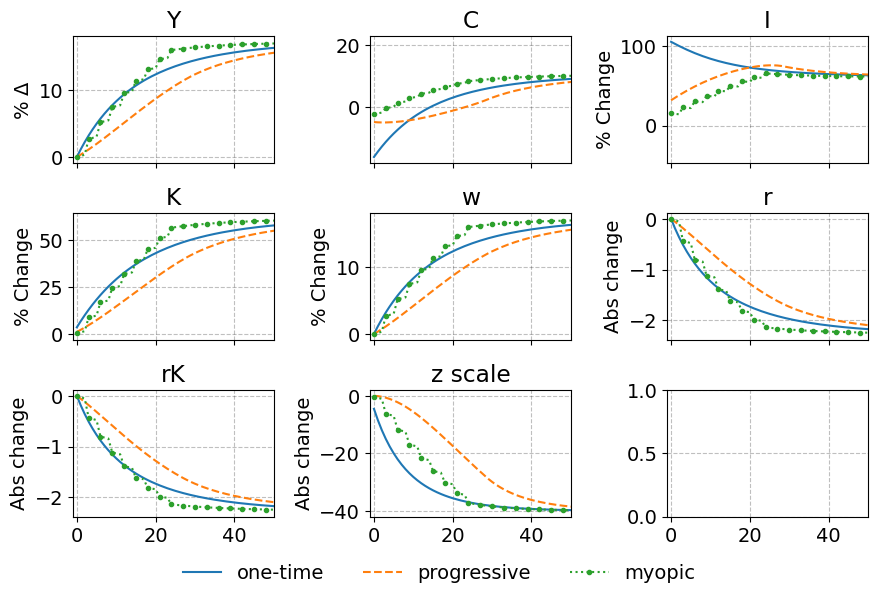

In [88]:
# use this code to plot your results 

def get_pc_myopic(trans, var):
    var_ss = getattr(benchmark.ss, var)
    var_trans = trans[var]
    return 100 * (var_trans - var_ss) / var_ss

def get_ac_myopic(trans, var):
    var_ss = getattr(benchmark.ss, var)
    var_trans = trans[var]
    return 100 * (var_trans - var_ss)


fig, axs = plt.subplots(nrows=3, ncols=3,
                        figsize=(9,6), sharex=True, sharey=False)

# Normalize axs to 1D list for easy iteration
axs = np.atleast_1d(axs).ravel()

axs[0].plot(get_pc_ini(trans, 'Y'), label = 'one-time'); axs[0].set_title("Y")
axs[0].plot(get_pc_ini(trans_progressive, 'Y'), linestyle = '--', label = 'progressive')
axs[0].plot(get_pc_myopic(full_trans, 'Y'), label = 'myopic', linestyle = ':', marker = '.', markevery=3)
axs[0].set_ylabel('% $\Delta$')

axs[1].plot(get_pc_ini(trans, 'C_hh')); axs[1].set_title("C")
axs[1].plot(get_pc_ini(trans_progressive, 'C_hh'), linestyle = '--')
axs[1].plot(get_pc_myopic(full_trans, 'C_hh'), label = 'myopic', linestyle = ':', marker = '.', markevery=3)

axs[2].plot(get_pc_ini(trans, 'I')); axs[2].set_title("I")
axs[2].plot(get_pc_ini(trans_progressive, 'I'), linestyle = '--')
axs[2].plot(get_pc_myopic(full_trans, 'I'), label = 'myopic', linestyle = ':', marker = '.', markevery=3)
axs[2].set_ylabel('% Change')

axs[3].plot(get_pc_ini(trans, 'K')); axs[3].set_title("K")
axs[3].plot(get_pc_ini(trans_progressive, 'K'), linestyle = '--')
axs[3].plot(get_pc_myopic(full_trans, 'K'), label = 'myopic', linestyle = ':', marker = '.', markevery=3)
axs[3].set_ylabel('% Change')

axs[4].plot(get_pc_ini(trans, 'w')); axs[4].set_title("w")
axs[4].plot(get_pc_ini(trans_progressive, 'w'), linestyle = '--')
axs[4].plot(get_pc_myopic(full_trans, 'w'), label = 'myopic', linestyle = ':', marker = '.', markevery=3)
axs[4].set_ylabel('% Change')

axs[5].plot(get_ac_ini(trans, 'r')); axs[5].set_title("r")
axs[5].plot(get_ac_ini(trans_progressive, 'r'), linestyle = '--')
axs[5].plot(get_ac_myopic(full_trans, 'r'), label = 'myopic', linestyle = ':', marker = '.', markevery=3)
axs[5].set_ylabel('Abs change')

axs[6].plot(get_ac_ini(trans, 'rK')); axs[6].set_title("rK")
axs[6].plot(get_ac_ini(trans_progressive, 'rK'), linestyle = '--')
axs[6].plot(get_ac_myopic(full_trans, 'rK'), label = 'myopic', linestyle = ':', marker = '.', markevery=3)
axs[6].set_ylabel('Abs change')

axs[7].plot(get_ac_ini(trans, 'z_scale')); axs[7].set_title("z scale")
axs[7].plot(get_ac_ini(trans_progressive, 'z_scale'), linestyle = '--')
axs[7].plot(get_ac_myopic(full_trans, 'z_scale'), label = 'myopic', linestyle = ':', marker = '.', markevery=3)
axs[7].set_ylabel('Abs change')

axs[0].set_xlim(-1, 50)

# Collect legend entries from the first axes (they all share the same labels)
handles, labels = axs[0].get_legend_handles_labels()

# Place the legend below all subplots
fig.legend(handles, labels,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.02),
           ncol=3, frameon=False)

fig.tight_layout()
plt.subplots_adjust(bottom=0.12)  # make space for the legend

plt.show()

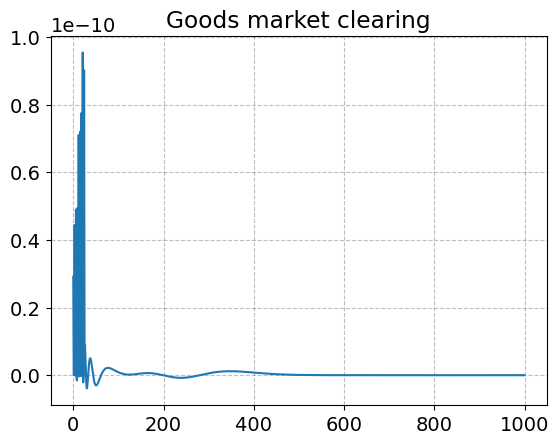

In [ ]:
plt.plot(full_trans['clearing_Y'])
plt.title('Goods market clearing')
plt.show()